In [4]:
import requests
import time
import calendar
import dateutil.parser as parser
from dateutil.relativedelta import relativedelta
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import warnings
import yaml
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from pycaret.datasets import get_data
from pycaret.classification import *

### Get Candlestick Data

In [5]:
now = datetime.now()

In [6]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    k_number = cfg['knn']['k_number']
    metric = cfg['knn']['metric']
    algorithm = cfg['knn']['algorithm']
    feature_1 = cfg['knn']['feature_1']
    feature_2 = cfg['knn']['feature_2']
    feature_3 = cfg['knn']['feature_3']
    feature_7 = cfg['knn']['feature_7']
    feature_8 = cfg['knn']['feature_8']
    feature_9 = cfg['knn']['feature_9']
    feature_10 = cfg['knn']['feature_10']
    feature_11 = cfg['knn']['feature_11']
    feature_12 = cfg['knn']['feature_12']
    feature_13 = cfg['knn']['feature_13']
    feature_14 = cfg['knn']['feature_14']
    volume = cfg['feature']['volume']
    volume_size = cfg['sample']['volume_size']
    sample_count = cfg['sample']['count']
    candles = cfg['recommendation']['candle_count']
    pair = cfg['currency']['pair']
    instrument = cfg['currency']['instrument']
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']
    model = cfg['model']['name']

In [7]:
print('K Number:',k_number)
print('Metric:', metric)
print('Algorithm:', algorithm)
print('Candle Volume Size:', volume_size)
print('Random Sample Count:', sample_count)
print('Future Candle Count:', candles)
print('Pair:', pair)

K Number: 5
Metric: euclidean
Algorithm: brute
Candle Volume Size: 3000
Random Sample Count: 10000
Future Candle Count: 7
Pair: USDCAD


In [8]:
with open ('config.yml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    oanda_api_key = cfg['creds']['oanda_api']
    account_number = cfg['creds']['account_number'] 

In [9]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [10]:
print('Instrument:', instrument)

Instrument: USD_CAD


In [8]:
Load_10K_Records=True
Load_20K_Records=True

currency_pairs = [instrument]


timeframe = "H4"
#D #H1 #H4 M30
# https://developer.oanda.com/rest-live-v20/instrument-df/#CandlestickGranularity
price_char = "M"
#M(midpoint candles) #B(bid candles) #A(ask candles) #BA
price_com = "mid"
#mid #bid #ask

# def of OANDA request variable
provider_api_url = 'https://api-fxpractice.oanda.com/v3/accounts/{}/orders'.format(account_number)
request_headers = {
    "Authorization": oanda_api_key,
    "Accept-Datetime-Format": "RFC3339",
    "Connection": "Keep-Alive",
    "Content-Type": "application/json;charset=UTF-8"
}


In [9]:
provider_authorization = 'Bearer {0}'.format(oanda_api_key)

headers = {
    'Content-Type': 'application/json',
    'Authorization': provider_authorization,
}

In [10]:
params_count = (
    ('price', price_char),
    ('count', '5000'),
    ('granularity', timeframe),
)


In [11]:
for pair in currency_pairs:
    first_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair), 
                            headers=headers,
                            params=params_count).json()

In [12]:
if Load_10K_Records:
    
    #### Load 10K data
        
    datetime_object = parser.parse(first_response['candles'][0]['time'])
    date= datetime_object - relativedelta(years=3)  
    from_date = date.replace(tzinfo=timezone.utc).timestamp()
    params_date = (
        ('count', '5000'),
        ('price', price_char),
        ('from', from_date),
        ('granularity', timeframe),)

    second_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                   headers=headers,
                                   params=params_date).json()
    datetime_object_15K = parser.parse(second_response['candles'][0]['time'])
    first_response= first_response['candles']  
    second_response= second_response['candles']
    second_response.extend(first_response)
    
    if Load_20K_Records:

        #### Load 15K data

        date= datetime_object_15K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        third_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(third_response['candles'][0]['time'])
        third_response= third_response['candles']
        third_response.extend(second_response)

        #### Load 20K data

        date= datetime_object_20K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        fourth_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(fourth_response['candles'][0]['time'])
        fourth_response= fourth_response['candles']
        fourth_response.extend(third_response)

        response=fourth_response
    else:
       response=second_response 
else:
    response=first_response['candles']

In [13]:
filename = "{}_{}.csv".format(pair, timeframe)
output = []
all_candlesticks = response

for i in range (len(all_candlesticks)):
    result= (convert_date(response[i]['time']))
    output.append([(result[0]),(result[1]),(result[2]),(result[3]),(result[4]),(result[5]),
                    response[i]['time'],
                    response[i]['volume'], 
                    response[i][price_com]['o'],
                    response[i][price_com]['h'],
                    response[i][price_com]['l'],
                    response[i][price_com]['c']])
    
output = pd.DataFrame(output)
output.columns = ['Date','Time','f_time','julian_date','Weekday','Weekday_Name','UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close']
data = output.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [14]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [15]:
data.shape

(19337, 12)

In [16]:
data['SMA_5'] = data['Close'].rolling(window=5).mean().round(4)
data['SMA_10'] = data['Close'].rolling(window=10).mean().round(4)
data['SMA_20'] = data['Close'].rolling(window=20).mean().round(4)

In [17]:
data['F_SMA_5'] = data['Close'] - data['SMA_5']
data['F_SMA_10'] = data['Close'] - data['SMA_10']
data['F_SMA_20'] = data['Close'] - data['SMA_20']

In [18]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [19]:
data['O-H'] = data['Open'] - data['High']
data['O-L'] = data['Open'] - data['Low']
data['O-C'] = data['Open'] - data['Close']
data['H-L'] = data['High'] - data['Low']
data['H-C'] = data['High'] - data['Close']
data['L-C'] = data['Low'] - data['Close']

data['Direction'] = data['O-C'].apply(lambda x: 1 if x<0 else 0)

data['col_1'] = data['Open'] - data['Close']

for value in data['col_1']:   
    if value > 0:
        data['col_2'] = data['High'] - data['Open']
        data['col_3'] = data['Close'] - data['Low']
    else:
        data['col_2'] = data['High'] - data['Close']
        data['col_3'] = data['Open'] - data['Low']

#Two Previous Candlesticks 
data['col_4'] = data['col_1'].shift(1)
data['col_5'] = data['col_1'].shift(2)

In [20]:
data = data.dropna()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [21]:
data.shape

(19318, 30)

### Generating Training Data

In [22]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [23]:
print('K Number:',k_number)
print('Metric:', metric)
print('Algorithm:', algorithm)

K Number: 5
Metric: euclidean
Algorithm: brute


In [11]:
def find_k_similar_candles(candle_id, dataset, k = k_number):
    indices=[]
    distances = []
    output = []
    model_knn = NearestNeighbors(metric = metric, algorithm = algorithm) 
    model_knn.fit(dataset)
    
    #metric = 'euclidean' or 'cosine' or 'manhattan' or 'mahalanobis'
    
    distances, indices = model_knn.kneighbors(dataset.iloc[candle_id,:].values.reshape(1,-1),
                                              n_neighbors = k)

    for i in range(0,len(distances.flatten())):
        if i!=0:
            
            output.append ([dataset.index[indices.flatten()[i]],
                            distances.flatten()[i],
                            dataset.iloc[indices.flatten()[i]][feature_9],
                            dataset.iloc[indices.flatten()[i]][feature_10],
                            dataset.iloc[indices.flatten()[i]][feature_11],
                            dataset.iloc[indices.flatten()[i]][feature_12],
                            dataset.iloc[indices.flatten()[i]][feature_13],
                            dataset.iloc[indices.flatten()[i]][feature_14],
                           ])
    
    output = pd.DataFrame(output)
    output.columns = ['Indice','Distance',
                      feature_9,
                      feature_10,
                      feature_11,
                      feature_12,
                      feature_13,
                      feature_14,
                     ]
   # display (output)
    
    return indices, distances

# <font color='red'>Test Configs</font>

In [25]:
filename = '{}_H4.csv'.format(instrument)
data = pd.read_csv(filename)

In [26]:
data.columns

Index(['Date', 'Time', 'f_time', 'julian_date', 'Weekday', 'Weekday_Name',
       'UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close', 'SMA_5', 'SMA_10',
       'SMA_20', 'F_SMA_5', 'F_SMA_10', 'F_SMA_20', 'O-H', 'O-L', 'O-C', 'H-L',
       'H-C', 'L-C', 'Direction', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5'],
      dtype='object')

## Selecting n random candles where their volume is more than x

In [27]:
print('Candle Volume Size:', volume_size)
print('Random Sample Count:', sample_count)

Candle Volume Size: 3000
Random Sample Count: 10000


In [28]:
random_samples = data[data[volume] > volume_size].sample(n = sample_count)

In [29]:
#Random_Candles = np.random.randint(low=1, high=len(data)-40, size=1000)
Random_Candles = list(random_samples.index.values)

# <font color='red'>CANDLE LOOP</font>

In [30]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [31]:
%%time
print ('Today: ' + today)

result_output = pd.DataFrame({'Candle_No':[],
                              'Current_Market_Fit':[],
                              'Current_Market':[],
                              'Rec1_Score':[],
                              'Rec1_Prediction':[],
                              'Rec2_Score':[],
                              'Rec2_Prediction':[],
                              'Rec3_Score':[],
                              'Rec3_Prediction':[],
                              'Rec4_Score':[],
                              'Rec4_Prediction':[]
                             })

for candle_no in Random_Candles:
    data = pd.read_csv(filename)
    data = data.iloc[candle_no:candle_no+candles]
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X) 
    
    Current_Market_Fit = r2_score(Y, y_pred)*100
    #print(Current_Market_Fit)
    coeficient = (linear_regressor.coef_)

    if coeficient > 0:
        Current_Market='Bullish'
    else:
        Current_Market = 'Bearish'
    
    data = pd.read_csv(filename)
    data = data[[feature_9,
                 feature_10,
                 feature_11,
                 feature_12,
                 feature_13,
                 feature_14,
                ]]

    indices, distances = find_k_similar_candles (candle_no,data)
    indices = indices[0:1][0]
    
    predicted_output = []
    recs = []
    for indice in indices[1:5]:
             
        Predicted_Market_Fit =0
        Predicted_Trade=''
    
        data = pd.read_csv(filename) 
        data = data.iloc[indice:indice+candles]

        data['candleno'] = range (1, len(data) + 1)
        X = data['candleno'].values.reshape(-1, 1)
        Y = data['Close'].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        y_pred = linear_regressor.predict(X)

        Predicted_Market_Fit= r2_score(Y, y_pred)*100
        coeficient = (linear_regressor.coef_)

        if coeficient > 0:
            Predicted_Trade= 'BUY'
        else:
            Predicted_Trade = 'SELL'
        
        predicted_output.append([Predicted_Market_Fit,Predicted_Trade])
        
    result = {'Candle_No': candle_no,
              'Current_Market_Fit': Current_Market_Fit,
              'Current_Market': Current_Market,
              'Rec1_Score': predicted_output[0][0],
              'Rec1_Prediction': predicted_output[0][1],
              'Rec2_Score': predicted_output[1][0],
              'Rec2_Prediction': predicted_output[1][1],
              'Rec3_Score': predicted_output[2][0],
              'Rec3_Prediction': predicted_output[2][1],
              'Rec4_Score': predicted_output[3][0],
              'Rec4_Prediction': predicted_output[3][1],
             }
    
    result_output = result_output.append(result, ignore_index = True)

Today: 03-02-2022_05-52_AM
CPU times: user 5h 44min 43s, sys: 6h 35min 52s, total: 12h 20min 36s
Wall time: 2h 21min 24s


In [32]:
result_output.to_csv('01_Back_Test_Data.csv', header = True, index = False)
result_output.to_csv(today + "_" + "Back_Test_Data_" + pair + '.csv', header = True, index = False)
result_output = pd.read_csv(today + "_" + "Back_Test_Data_" + pair + '.csv')
result_output.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,6354.0,76.396898,Bullish,4.856388,BUY,84.785176,SELL,0.005017,SELL,89.815241,BUY
1,13219.0,88.157364,Bullish,0.086286,BUY,43.112294,SELL,50.851924,BUY,76.716886,SELL
2,8377.0,62.354548,Bullish,48.205270,SELL,59.764444,BUY,94.008315,BUY,5.493361,SELL
3,746.0,21.014449,Bearish,50.716516,SELL,6.639818,BUY,37.234889,SELL,34.484439,SELL
4,12635.0,61.132288,Bullish,18.878100,BUY,25.433133,SELL,49.368088,BUY,46.759774,BUY


In [33]:
result_output.shape

(10000, 11)

#### Generating Log File

In [34]:
file = open(today + "_" + "data_generation_log_" + pair + '.txt', "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "K_Number: " + str(k_number) + "\n" + \
            "KNN_Metric: " + metric + "\n" + \
            "KNN_Algorithm: " + algorithm + "\n" + \
            "Feature: " + feature_9 + "\n" + \
            "Feature: " + feature_10 + "\n" + \
            "Feature: " + feature_11 + "\n" + \
            "Feature: " + feature_12 + "\n" + \
            "Feature: " + feature_13 + "\n" + \
            "Feature: " + feature_14 + "\n" + \
            "Volume Size: " + str(volume_size) + "\n" + \
            "Sample Count: " + str(sample_count) + "\n" + \
            "Candle Counts: " + str(candles) + "\n"
           )
file.close()

### Modeling

In [12]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']

In [13]:
print('Pair:', pair)
print('Fraction:', frac)
print('Random State:', random_state)

Pair: USDCAD
Fraction: 0.7
Random State: 800


In [14]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [15]:
dataset = pd.read_csv('01_Back_Test_Data.csv')
dataset.shape

(10000, 11)

In [16]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [17]:
dataset.shape

(7193, 11)

In [18]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [19]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [20]:
dataset['Rec1_Score'] = dataset['Rec1_Score'].round(2)
dataset['Rec2_Score'] = dataset['Rec2_Score'].round(2)
dataset['Rec3_Score'] = dataset['Rec3_Score'].round(2)
dataset['Rec4_Score'] = dataset['Rec4_Score'].round(2)

In [21]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [22]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,4.86,-84.79,-0.01,89.82
1,1,0.09,-43.11,50.85,-76.72
2,1,-48.21,59.76,94.01,-5.49
3,0,-50.72,6.64,-37.23,-34.48
4,1,18.88,-25.43,49.37,46.76


In [23]:
data = dataset.sample(frac=frac, random_state=random_state).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
print('Fraction: ' + str(frac))
#print('Random State: ', str(random_state))

Data for Modeling: (5035, 5)
Unseen Data For Predictions: (2158, 5)
Fraction: 0.7


In [24]:
data_unseen.shape

(2158, 5)

In [25]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,-23.29,-57.66,-60.69,-77.74
1,1,-66.05,-47.32,88.79,72.47
2,0,-8.43,70.87,8.61,31.91
3,0,-3.83,-21.66,-81.80,60.85
4,0,-61.76,69.59,-52.19,20.35


In [26]:
exp_name = setup(data = data,
                 target = 'Current_Market',
#                 fold_shuffle=True,
                 session_id=123,
                 silent=True,
#                 n_jobs = 64,
#                 imputation_type='iterative'
                ) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5035, 5)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [27]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5131,0.5131,0.5388,0.5237,0.5307,0.0249,0.0249,0.0980
svm,SVM - Linear Kernel,0.5094,0.0000,0.5188,0.5196,0.5187,0.0183,0.0184,0.1870
knn,K Neighbors Classifier,0.5082,0.5151,0.5266,0.5192,0.5227,0.0156,0.0156,0.1880
dt,Decision Tree Classifier,0.5080,0.5079,0.5083,0.5199,0.5140,0.0159,0.0159,0.2050
nb,Naive Bayes,0.5060,0.5047,0.7749,0.5113,0.6159,-0.0012,-0.0008,0.1860
gbc,Gradient Boosting Classifier,0.5057,0.5030,0.5875,0.5150,0.5485,0.0073,0.0075,0.0730
rf,Random Forest Classifier,0.5054,0.5047,0.5288,0.5166,0.5221,0.0096,0.0097,0.2610
qda,Quadratic Discriminant Analysis,0.5023,0.4906,0.7316,0.5092,0.6001,-0.0067,-0.0064,0.0080
ada,Ada Boost Classifier,0.5023,0.5031,0.5937,0.5121,0.5494,0.0001,-0.0000,0.0310
lightgbm,Light Gradient Boosting Machine,0.5003,0.5082,0.5393,0.5115,0.5248,-0.0014,-0.0014,0.0220


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [28]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    model = cfg['model']['name']

In [29]:
print('Model Name:', model)

Model Name: knn


In [30]:
MODEL = create_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4618,0.4630,0.4917,0.4759,0.4837,-0.0781,-0.0782
1,0.5042,0.5128,0.5249,0.5163,0.5205,0.0074,0.0074
2,0.4929,0.4889,0.5359,0.5052,0.5201,-0.0164,-0.0165
3,0.5524,0.5584,0.5967,0.5596,0.5775,0.1027,0.1029
4,0.4716,0.4886,0.4833,0.4833,0.4833,-0.0574,-0.0574
5,0.5227,0.5046,0.5667,0.5312,0.5484,0.0435,0.0436
6,0.5114,0.5209,0.5111,0.5227,0.5169,0.0227,0.0227
7,0.5398,0.5607,0.5500,0.5500,0.5500,0.0791,0.0791
8,0.5511,0.5692,0.5500,0.5625,0.5562,0.1023,0.1023
9,0.4744,0.4839,0.4556,0.4852,0.4699,-0.0502,-0.0503


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


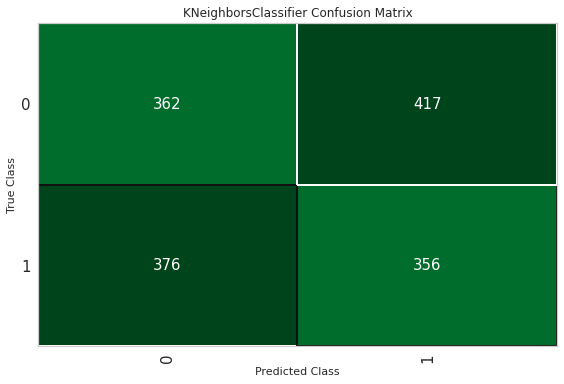

In [31]:
plot_model(MODEL, plot = 'confusion_matrix')

In [32]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5071,0.4834,0.5359,0.5187,0.5272,0.0127,0.0127
1,0.5042,0.5029,0.5525,0.5155,0.5333,0.0060,0.0060
2,0.4674,0.4547,0.5414,0.4828,0.5104,-0.0692,-0.0698
3,0.5581,0.5663,0.6022,0.5648,0.5829,0.1140,0.1143
4,0.4631,0.4689,0.4611,0.4743,0.4676,-0.0737,-0.0738
5,0.5256,0.5273,0.6000,0.5320,0.5640,0.0478,0.0482
6,0.4830,0.5089,0.4944,0.4944,0.4944,-0.0346,-0.0346
7,0.5710,0.5687,0.5778,0.5810,0.5794,0.1417,0.1417
8,0.5511,0.5526,0.5722,0.5598,0.5659,0.1013,0.1014
9,0.4858,0.4806,0.4889,0.4972,0.4930,-0.0285,-0.0285


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


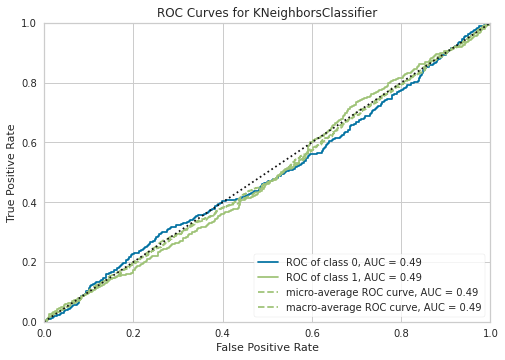

In [33]:
plot_model(TUNED_MODEL, plot = 'auc')

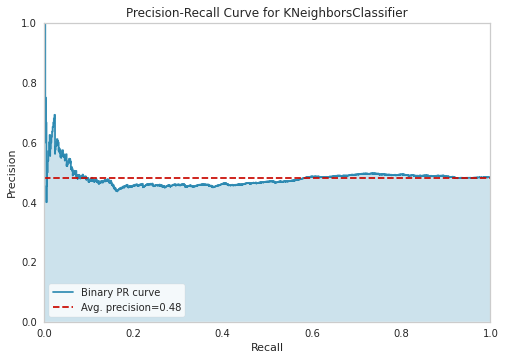

In [34]:
plot_model(TUNED_MODEL, plot = 'pr')

In [35]:
plot_model(TUNED_MODEL, plot='feature')

TypeError: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

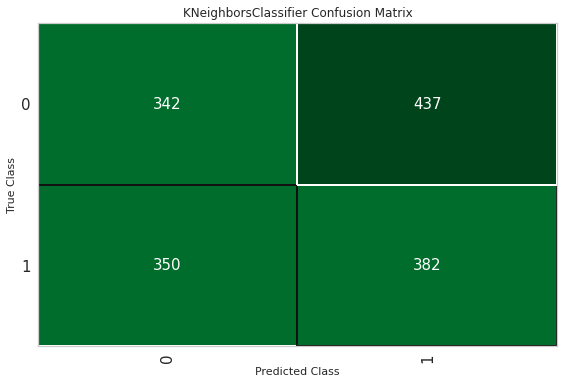

In [36]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [37]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.4792,0.4892,0.5219,0.4664,0.4926,-0.0390,-0.0392


In [38]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [39]:
print(FINAL_MODEL)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='distance')


In [40]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [41]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-23.29,-57.66,-60.69,-77.74,1,1.0
1,1,-66.05,-47.32,88.79,72.47,1,1.0
2,0,-8.43,70.87,8.61,31.91,0,1.0
3,0,-3.83,-21.66,-81.80,60.85,0,1.0
4,0,-61.76,69.59,-52.19,20.35,0,1.0


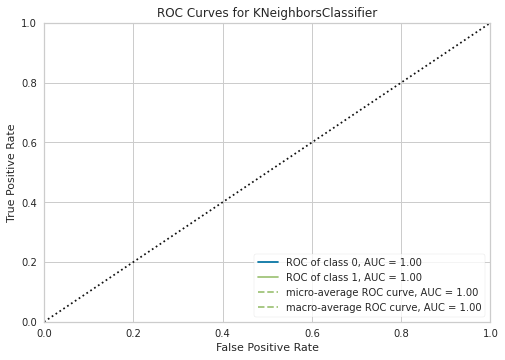

In [42]:
plot_model(FINAL_MODEL, plot = 'auc')

In [43]:
pkl_name = (today + "_" + model + "_" + pair)

In [44]:
save_model(FINAL_MODEL, pkl_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                 ('fix_perfect', Remove_100(target='Current_Market')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'p

In [45]:
SAVED_FINAL_MODEL = load_model(pkl_name)

Transformation Pipeline and Model Successfully Loaded


In [46]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [47]:
data_unseen.shape

(2158, 5)

In [48]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-23.29,-57.66,-60.69,-77.74,1,1.0000
1,1,-66.05,-47.32,88.79,72.47,1,1.0000
2,0,-8.43,70.87,8.61,31.91,0,1.0000
3,0,-3.83,-21.66,-81.80,60.85,0,1.0000
4,0,-61.76,69.59,-52.19,20.35,0,1.0000
5,0,48.93,-76.55,-26.24,49.54,0,1.0000
6,0,4.71,-39.19,76.02,17.20,0,0.5140
7,0,-0.30,62.61,48.64,59.11,0,1.0000
8,0,85.99,10.30,41.54,-40.44,0,1.0000
9,1,-15.59,47.92,-34.33,-35.06,1,1.0000


In [49]:
file = open(today + "_" + model + "_binary_classification_log_" + pair + ".txt", "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "Model: " + model + "\n" + \
            "Frac: " + str(frac) + "\n" + \
            "Random State: " + str(random_state) + "\n" )
file.close()

### Final Test

In [50]:
filename = '{}_H4.csv'.format(instrument)
data = pd.read_csv(filename)

In [51]:
random_samples = data[data[volume] > volume_size].sample(n = sample_count)
Test_Candle = list(random_samples.index.values)

In [52]:
#LR_FINAL_MODEL = load_model('FINAL_MODELS/EURUSD/FINAL_LR_25Nov2021_EURUSD')
#ET_FINAL_MODEL = load_model('FINAL_MODELS/EURUSD/FINAL_ET_25Nov2021_EURUSD')
KNN_FINAL_MODEL = load_model('03-02-2022_09-52_PM_knn_USDCAD')
#DT_FINAL_MODEL = load_model('FINAL_MODELS/USDCAD/10-01-2022_06-15_AM_dt_USDCAD')
#GBC_FINAL_MODEL = load_model('FINAL_MODELS/USDCAD/10-01-2022_07-12_AM_gbc_USDCAD')
#LIGHTGBM_FINAL_MODEL = load_model('FINAL_MODELS/GBPUSD/09-01-2022_10-58_PM_lightgbm_GBPUSD')

Transformation Pipeline and Model Successfully Loaded


In [53]:
%%time
print ('Today: ' + today)

result_output = pd.DataFrame({'Candle_No':[],
                              'Current_Market_Fit':[],
                              'Current_Market':[],
#                              'Rec1':[],
#                              'Rec1_P':[],
#                              'Rec2':[],
#                              'Rec2_P':[],
#                              'Rec3':[],
#                              'Rec3_P':[],
#                              'LR_Label':[],
#                              'LR_Score':[],
#                              'ET_Label':[],
#                              'ET_Score':[],
                              'KNN_Label':[],
                              'KNN_Score':[],
#                              'DT_Label':[],
#                              'DT_Score':[],
#                              'LIGHTGBM_Label':[],
#                              'LIGHTGBM_Score':[],
#                              'GBC_Label':[],
#                              'GBC_Score':[],                              
                             })

for candle_no in Test_Candle:
    data = pd.read_csv(filename)
    data = data.iloc[candle_no:candle_no+candles]
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X) 
    
    Current_Market_Fit = r2_score(Y, y_pred)*100
    coeficient = (linear_regressor.coef_)

    if coeficient > 0:
        Current_Market= 1

    else:
        Current_Market = 0

    data = pd.read_csv(filename)
    data = data[[feature_9,
                 feature_10,
                 feature_11,
                 feature_12,
                 feature_13,
                 feature_14,
                ]]

    indices, distances = find_k_similar_candles (candle_no,data)
    indices = indices[0:1][0]
    
    predicted_output = []
    recs = []
    for indice in indices[1:5]:
             
        Predicted_Market_Fit =0
        Predicted_Trade=''
    
        data = pd.read_csv(filename) 
        data = data.iloc[indice:indice+candles]

        data['candleno'] = range (1, len(data) + 1)
        X = data['candleno'].values.reshape(-1, 1)
        Y = data['Close'].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        y_pred = linear_regressor.predict(X)

        Predicted_Market_Fit= r2_score(Y, y_pred)*100
        coeficient = (linear_regressor.coef_)

        if coeficient > 0:
            Predicted_Trade = 'BUY'
            recs.append((r2_score(Y, y_pred)*100))
        else:
            Predicted_Trade = 'SELL'
            recs.append((r2_score(Y, y_pred)*100) * -1)
        
        predicted_output.append([Predicted_Market_Fit,Predicted_Trade])
        
        
    data_unseen = pd.DataFrame ({
        'Rec1_Score': [recs[0]],
        'Rec2_Score': [recs[1]],
        'Rec3_Score': [recs[2]],
        'Rec4_Score': [recs[3]],
    })
    
#    lr_prediction = predict_model(LR_FINAL_MODEL, data=data_unseen)
#    LR_Label = lr_prediction['Label']
#    LR_Score = lr_prediction['Score']
    
#    et_prediction = predict_model(ET_FINAL_MODEL, data=data_unseen)
#    ET_Label = et_prediction['Label']
#    ET_Score = et_prediction['Score']
    
    knn_prediction = predict_model(KNN_FINAL_MODEL, data=data_unseen)
    KNN_Label = knn_prediction['Label']
    KNN_Score = knn_prediction['Score']
    
#    dt_prediction = predict_model(DT_FINAL_MODEL, data=data_unseen)
#    DT_Label = dt_prediction['Label']
#    DT_Score = dt_prediction['Score']
    
#    lightgbm_prediction = predict_model(LIGHTGBM_FINAL_MODEL, data=data_unseen)
#    LIGHTGBM_Label = lightgbm_prediction['Label']
#    LIGHTGBM_Score = lightgbm_prediction['Score']

#    gbc_prediction = predict_model(GBC_FINAL_MODEL, data=data_unseen)
#    GBC_Label = gbc_prediction['Label']
#    GBC_Score = gbc_prediction['Score']    
    
    result = {'Candle_No': candle_no,
              'Current_Market_Fit': Current_Market_Fit,
              'Current_Market': Current_Market,
#              'Rec1': predicted_output[0][0],
#              'Rec1_P': predicted_output[0][1],
#              'Rec2': predicted_output[1][0],
#              'Rec2_P': predicted_output[1][1],
#              'Rec3': predicted_output[2][0],
#              'Rec3_P': predicted_output[2][1],
#              'LR_Label': LR_Label[0],
#              'LR_Score': LR_Score[0],
#              'ET_Label': ET_Label[0],
#              'ET_Score': ET_Score[0],
              'KNN_Label': KNN_Label[0],
              'KNN_Score': KNN_Score[0],
#              'DT_Label': DT_Label[0],
#              'DT_Score': DT_Score[0],
#              'LIGHTGBM_Label': LIGHTGBM_Label[0],
#              'LIGHTGBM_Score': LIGHTGBM_Score[0],
#              'GBC_Label': GBC_Label[0],
#              'GBC_Score': GBC_Score[0],              
             }
    
    result_output = result_output.append(result, ignore_index = True)

Today: 03-02-2022_09-52_PM


/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 8h 6min 46s, sys: 9h 45min 8s, total: 17h 51min 54s
Wall time: 2h 32min 45s


In [54]:
result_output.to_csv('03_Back_Test_Final_Result_' + today + '.csv', header = True, index = False)
result_output = pd.read_csv('03_Back_Test_Final_Result_' + today + '.csv')

In [55]:
result_output = result_output[result_output['Current_Market_Fit'] > 20]
result_output = result_output.reset_index()
del result_output['index']

In [56]:
result_output.shape

(7190, 5)

In [57]:
result_output.to_csv('03_Back_Test_Final_Result_' + today + '.csv', header = True, index = False)
result_output = pd.read_csv('03_Back_Test_Final_Result_' + today + '.csv')

In [58]:
#result_output['LR_Prediction'] = result_output['Current_Market'] - result_output['LR_Label']
#result_output['ET_Prediction'] = result_output['Current_Market'] - result_output['ET_Label']
result_output['KNN_Prediction'] = result_output['Current_Market'] - result_output['KNN_Label']
#result_output['DT_Prediction'] = result_output['Current_Market'] - result_output['DT_Label']
#result_output['LIGHTGBM_Prediction'] = result_output['Current_Market'] - result_output['LIGHTGBM_Label']
#result_output['GBC_Prediction'] = result_output['Current_Market'] - result_output['GBC_Label']

In [59]:
KNN_Result = pd.DataFrame(result_output['KNN_Prediction'].value_counts())
KNN_Result["Score"] = (KNN_Result['KNN_Prediction'] * 100 / len(result_output)).round(2)

In [60]:
result = pd.concat([
#    LR_Result,
#    ET_Result,
    KNN_Result,
#    DT_Result,
#    GBC_Result,
#    LIGHTGBM_Result,
], axis=1)
result

,KNN_Prediction,Score
0.0,5539,77.04
1.0,828,11.52
-1.0,823,11.45
